In [1]:
!pip install tensorflow opencv-python matplotlib
!pip list

import tensorflow as tf
import os

# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

tf.config.list_physical_devices('GPU')



Package                            Version
---------------------------------- -------------------
absl-py                            1.4.0
alabaster                          0.7.12
anaconda-client                    1.7.2
anaconda-navigator                 1.10.0
anaconda-project                   0.8.3
argh                               0.26.2
argon2-cffi                        20.1.0
asn1crypto                         1.4.0
astroid                            2.4.2
astropy                            4.0.2
astunparse                         1.6.3
async-generator                    1.10
atomicwrites                       1.4.0
attrs                              20.3.0
autopep8                           1.5.4
Babel                              2.8.1
backcall                           0.2.0
backports.functools-lru-cache      1.6.1
backports.shutil-get-terminal-size 1.0.0
backports.tempfile                 1.0
backports.weakref                  1.0.post1
bcrypt                             

[]

In [2]:
# Remove Random Image
import cv2
import imghdr

data_dir = 'Dataset_DS'
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)



Found 2295 files belonging to 2 classes.


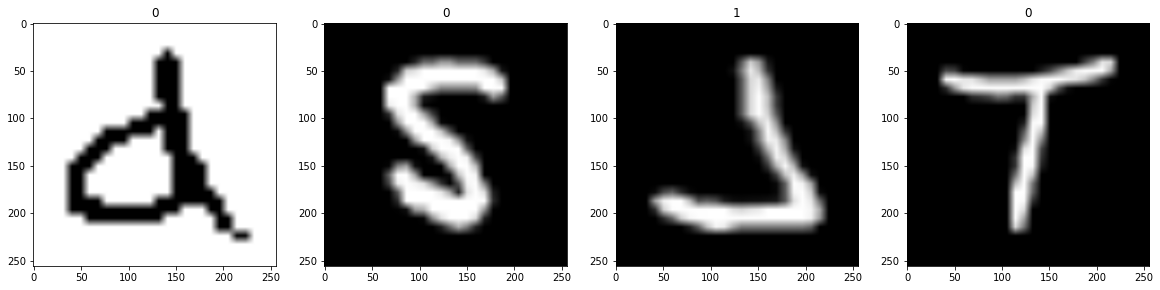

In [3]:
# Load Data
import numpy as np
from matplotlib import pyplot as plt

data = tf.keras.utils.image_dataset_from_directory('Dataset_DS')

data_iterator = data.as_numpy_iterator()

batch = data_iterator.next()

fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# Scale Data
data = data.map(lambda x, y: (x / 255, y))
data.as_numpy_iterator().next()

# Split Data
train_size = int(len(data) * 0.7)
val_size = int(len(data) * 0.2)
test_size = int(len(data) * 0.1)

train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)



In [4]:
# Build Dyslexia Scanner Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

model = Sequential()
model.add(Conv2D(16, (3, 3), 1, activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))  # Add dropout for regularization
model.add(Dense(1, activation='sigmoid'))

model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

In [7]:
# Train
logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])



Epoch 1/20
50/50 [==============================] - 162s 3s/step - loss: 0.0384 - accuracy: 0.9837 - val_loss: 0.1710 - val_accuracy: 0.9397
Epoch 2/20
50/50 [==============================] - 143s 3s/step - loss: 0.0351 - accuracy: 0.9887 - val_loss: 0.1679 - val_accuracy: 0.9554
Epoch 3/20
50/50 [==============================] - 175s 3s/step - loss: 0.0190 - accuracy: 0.9944 - val_loss: 0.2045 - val_accuracy: 0.9576
Epoch 4/20
50/50 [==============================] - 235s 5s/step - loss: 0.0186 - accuracy: 0.9950 - val_loss: 0.2482 - val_accuracy: 0.9598
Epoch 5/20
50/50 [==============================] - 142s 3s/step - loss: 0.0217 - accuracy: 0.9925 - val_loss: 0.1872 - val_accuracy: 0.9598
Epoch 6/20
50/50 [==============================] - 155s 3s/step - loss: 0.0161 - accuracy: 0.9944 - val_loss: 0.2245 - val_accuracy: 0.9665
Epoch 7/20
50/50 [==============================] - 124s 2s/step - loss: 0.0149 - accuracy: 0.9950 - val_loss: 0.3194 - val_accuracy: 0.9576
Epoch 8/20
50

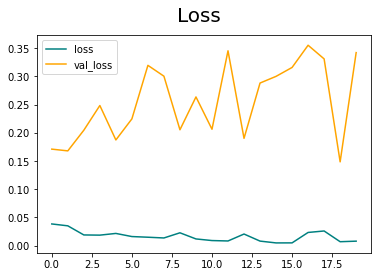

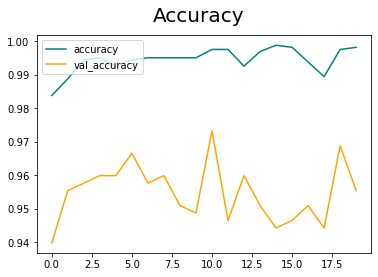

1/1 [==============================] - 3s 3s/step
Precision: 0.9487179517745972, Recall: 0.9367088675498962, Accuracy: 0.9598214030265808


In [8]:
# Plot Performance
# Loss
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# Accuracy
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# Evaluate
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

pre = Precision()
re = Recall()
acc = BinaryAccuracy()

for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

print(f'Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, Accuracy: {acc.result().numpy()}')



In [9]:
# Save Model
model.save(os.path.join('models', 'dyslexia_scanner_new.h5'))

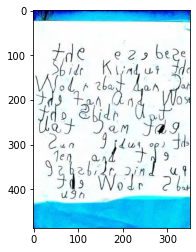

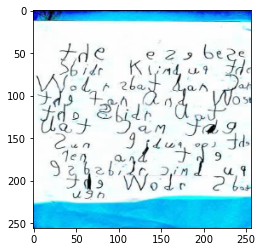

1/1 [==============================] - 0s 233ms/step
[[0.8047544]]
unfortunately you have >50% chance of suffering from dyslexia.


In [17]:
# Test Model
from tensorflow.keras.models import load_model
import tensorflow as tf
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt

new_model = load_model(os.path.join('models', 'dyslexia_scanner_new.h5'))

import cv2
img = cv2.imread('Dataset_DS/Test/test_dyslexia.jpeg')
plt.imshow(img)
plt.show()

resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

yhat = new_model.predict(np.expand_dims(resize/255, 0))

print(yhat)

if yhat > 0.5:
    print(f'unfortunately you have >50% chance of suffering from dyslexia.')
else:
    print(f'congratulations, you are normal')